# The Second Agent - estimate the actual value of a product

## RAG (Retrieval Augmented Generation) based on a dataset of 400,000 scraped Amazon products

#### For our 2nd agent, we will be asking DeekSeek to estimate the price of one of our deals - and we will give it a hand.

It turns out that LLMs are really good at this! Out of the box, GPT-4o is off by an average of \$76.

But we can do even better: we'll provide it with some context, in the form of 5 similar products from our training dataset

Again I'll be going quite quickly through this - the idea is for you to run this yourself.

In [1]:
# imports

import os
import re
import math
import json
import logging
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from testing import Tester
from openai import OpenAI

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')
DB = "products_vectorstore"

In [3]:
# Log in to HuggingFace
# If you don't have a HuggingFace account, you can set one up for free at www.huggingface.co
# And then add the HF_TOKEN to your .env file as explained in the project README

hf_token = os.environ['HF_TOKEN']
login(token=hf_token, add_to_git_credential=False)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# For following along at home:

Please download the files train.pkl and test.pkl from this Google Drive folder:  
https://drive.google.com/drive/folders/1t0YnoCXCbo2g08uWIOR6TPKR2-6Egb_g?usp=sharing

And place them in the parent directory (the directory called agentic).

In [4]:
# Load the training data

with open('../train.pkl', 'rb') as file:
    train = pickle.load(file)


In [5]:
print(f"There are {len(train):,} training items scraped from Amazon, and the first one is {train[0]}")

There are 400,000 training items scraped from Amazon, and the first one is <Delphi FG0166 Fuel Pump Module = $226.95>


# Now create a Chroma Datastore

Now we will use the free, open-source Vector database Chroma.  
We will create a Chroma datastore with 400,000 products from our training dataset.

In [6]:
client = chromadb.PersistentClient(path=DB)

# Introducing the SentenceTransformer Encoding LLM

The all-MiniLM is a very useful model from HuggingFace that maps sentences & paragraphs to 384 dimensional vectors and is ideal for tasks like semantic search.

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

It can run pretty quickly locally.

As an alternative, OpenAI provides a closed-source Embeddings model. Benefits compared to OpenAI embeddings:
1. It's free and fast!
3. We can run it locally, so the data never leaves our box - might be useful if you're building a personal RAG

In [7]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [8]:
# Pass in a list of texts, get back a numpy array of vectors

vector = model.encode(["A room full of software engineers"])[0]
print(vector.shape)
vector

(384,)


array([-1.07516926e-02, -3.26470137e-02,  1.49072730e-03, -1.16258441e-03,
        1.23239271e-02, -1.04110405e-01,  4.23309617e-02,  1.54848509e-02,
        8.58569145e-03, -1.91479474e-02, -5.22569269e-02, -6.39601052e-02,
        7.70011470e-02, -4.21598628e-02, -1.38169515e-03,  3.89790908e-02,
       -5.20618148e-02, -1.04253307e-01,  5.08281291e-02, -1.03140853e-01,
       -5.72729520e-02,  1.89593341e-02, -2.37538125e-02, -2.35941112e-02,
        4.17627767e-02,  7.25998804e-02,  4.73284684e-02, -1.88370179e-02,
        5.44371977e-02, -3.84208523e-02,  2.78962427e-03,  7.38718361e-02,
        7.02842474e-02,  5.30361421e-02,  8.85342285e-02,  7.76899308e-02,
       -2.84249824e-03, -6.90025464e-02,  3.75820175e-02,  2.84839943e-02,
       -1.00663275e-01,  2.71375049e-02,  4.32913862e-02,  2.81325877e-02,
       -2.92596724e-02, -8.14440846e-02,  1.13112684e-02, -8.49853382e-02,
        4.92296331e-02, -3.95888761e-02, -4.91748676e-02, -4.37014624e-02,
       -1.21951271e-02,  

In [9]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

vector1 = model.encode(["A room full of software engineers"])[0]
vector2 = model.encode(["A room full of data scientists"])[0]
cosine_similarity(vector1, vector2)

0.6501722

In [10]:
vector1 = model.encode(["A room full of software engineers"])[0]
vector3 = model.encode(["A hovercraft full of eels"])[0]
cosine_similarity(vector1, vector3)

0.10931375

In [11]:
# The sentence equivalent of the famous King - Man + Woman = Queen

room_engineers = model.encode(["A room full of software engineers"])[0]
room_scientists = model.encode(["A room full of data scientists"])[0]
engineers = model.encode(["software engineers"])[0]
scientists = model.encode(["data scientists"])[0]

In [12]:
cosine_similarity(room_engineers, room_scientists)

0.6501722

In [13]:
cosine_similarity(engineers, scientists)

0.52293795

In [14]:
new_room = room_engineers - engineers + scientists

In [15]:
cosine_similarity(new_room, room_scientists)

0.930619

## With that background, let's populate our Chroma database

### By calculating vectors for 400,000 scraped products

In [16]:
# Check if the collection exists; if not, create it

collection_name = "products"
existing_collection_names = [collection.name for collection in client.list_collections()]

if collection_name not in existing_collection_names:
    collection = client.create_collection(collection_name)
    for i in tqdm(range(0, len(train), 1000)):
        documents = [item.text for item in train[i: i+1000]]
        vectors = model.encode(documents).astype(float).tolist()
        metadatas = [{"category": item.category, "price": item.price} for item in train[i: i+1000]]
        ids = [f"doc_{j}" for j in range(i, i+1000)]
        collection.add(
            ids=ids,
            documents=documents,
            embeddings=vectors,
            metadatas=metadatas
        )
collection = client.get_or_create_collection(collection_name)

# Let's visualize the vectorized data

In [17]:
# It is very fun turning this up to 400_000 and seeing the full dataset visualized,
# but it almost crashes my box every time so do that at your own risk!! 5_000 is safe!

MAXIMUM_DATAPOINTS = 5_000

In [18]:
CATEGORIES = ['Appliances', 'Automotive', 'Cell_Phones_and_Accessories', 'Electronics','Musical_Instruments', 'Office_Products', 'Tools_and_Home_Improvement', 'Toys_and_Games']
COLORS = ['cyan', 'blue', 'brown', 'orange', 'yellow', 'green' , 'purple', 'red']

In [19]:
# Prework
result = collection.get(include=['embeddings', 'documents', 'metadatas'], limit=MAXIMUM_DATAPOINTS)
vectors = np.array(result['embeddings'])
documents = result['documents']
categories = [metadata['category'] for metadata in result['metadatas']]
colors = [COLORS[CATEGORIES.index(c)] for c in categories]

In [20]:
# Let's try a 2D chart
# TSNE stands for t-distributed Stochastic Neighbor Embedding - it's a common technique for reducing dimensionality of data

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
reduced_vectors = tsne.fit_transform(vectors)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


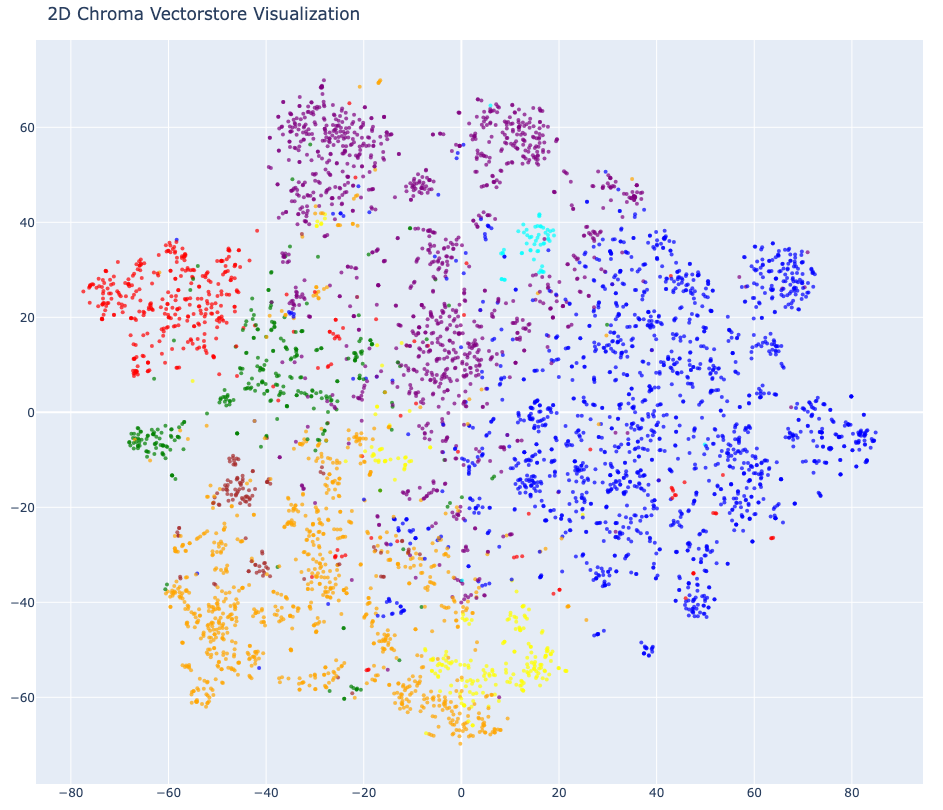

In [21]:
# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=4, color=colors, opacity=0.7),
    text=[f"Category: {c}<br>Text: {d[:50]}..." for c, d in zip(categories, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vectorstore Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y'),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

In [22]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42, n_jobs=-1)
reduced_vectors = tsne.fit_transform(vectors)

In [23]:
# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=2, color=colors, opacity=0.7),
    text=[f"Category: {c}<br>Text: {d[:50]}..." for c, d in zip(categories, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

In [24]:
# And now - set up OpenAI, Ollama and DeepSeek

# OpenAI
openai = OpenAI()

# Ollama
ollama_via_openai = OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')

# DeepSeek
deepseek_api_key = os.getenv("DEEPSEEK_API_KEY")
deepseek_via_openai_client = OpenAI(api_key=deepseek_api_key,base_url="https://api.deepseek.com")

In [25]:
# Load in the test pickle file

with open('../test.pkl', 'rb') as file:
    test = pickle.load(file)

In [26]:
# We need to give some context to DeepSeek by selecting 5 products with similar descriptions

def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [27]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [ ]:
!ollama pull llama3.2

In [28]:
def preprocess(item):
    system_message = "You rewrite product descriptions in a format most suitable for finding similar products in a Knowledge Base"
    user_message = "Please write a short 2-3 sentence description of the following product; your description will be used to find similar products so it should be comprehensive and only about the product. Details:\n"
    user_message += item
    user_message += "\n\nNow please reply only with the short description, with no introduction"
    messages = [{"role": "system", "content": system_message}, {"role": "user", "content": user_message}]
    response = ollama_via_openai.chat.completions.create(
        model="llama3.2",
        messages=messages,
        seed=42
    )
    return response.choices[0].message.content

In [29]:
def preprocess(item):
    user_message = "Write 2-3 sentences about this product. This will be used to find similar products so it should be comprehensive and only about the product. Details:\n"
    user_message += item
    user_message += "\n\nReply only with the short description, no introduction"
    messages = [{"role": "user", "content": user_message}]
    response = ollama_via_openai.chat.completions.create(
        model="llama3.2",
        messages=messages,
        seed=42
    )
    return response.choices[0].message.content

In [30]:
def vector(item):
    text = preprocess(item.text)
    return model.encode(text)

In [31]:
def find_similars(item):
    vec = vector(item)
    results = collection.query(query_embeddings=vec.astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [32]:
print(test[1].text)

Motorcraft YB3125 Fan Clutch
Motorcraft YB3125 Fan Clutch Package Dimensions 25.146 cms (L) x 20.066 cms (W) x 15.494 cms (H) Package Quantity 1 Product Type Auto Part Country Of Origin China Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch, Weight 5 pounds, Dimensions 10 x 7.63 x 6.25 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Rank Automotive Automotive Replacement Engine Fan Clutches 583, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of the U.S. Learn More, Available October 10, 2007


In [33]:
print(preprocess(test[1].text))

Motorcraft YB3125 Fan Clutch is a motor vehicle part intended for automotive replacement engine fan clutches; it measures approximately 1 x 2.63 inches in size and weighs around 0.25 pounds, replacing exterior painted fan clutch in various vehicles due to its domestic and international shipping options available starting from October 10, 2007.


In [34]:
documents, prices = find_similars(test[1])

In [35]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
Motorcraft Fan Clutch Assembly - YB3130
Motorcraft Fan Clutch Assembly - YB3130 Package Dimensions 7.23 L x 4 H x 6.92 W (inches) Package Weight 5 pounds Country of Origin China Part Number YB3130 Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch Assembly, Weight 5 pounds, Dimensions 6.87 x 7.32 x 5.62 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Wattage 6.92 watts, Rank Automotive Automotive Replacement Engine Fan Clutches 698, Available October 10, 2007, Dimensions LxWxH 6.87 x 7.32 x 5.62 inches
Price is $223.78

Potentially related product:
Motorcraft YB3188 Clutch
Premium aftermarket replacement parts for Ford and Lincoln vehicles, Tested to provide performance and long-life reliability. Two-year unlimited mileage warranty, labor included and no commercial exceptions. Leading Manufacturer Of High-Qua

In [36]:
# Utility function that extracts a price from a response from GPT-4.1-mini

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [37]:
get_price("blah blah the price is $99.99 blah")

99.99

In [38]:
# The function for gpt-4.1

def gpt_4_1_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4.1", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=8
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [39]:
# How much does the Fan Clutch in test[1] actually cost, on Amazon?

test[1].price

225.11

In [40]:
# Now let's call GPT-4o-mini using RAG, passing in 5 similar items from our Chroma datastore

gpt_4_1_rag(test[1])

235.0

In [41]:
# Try DeepSeek-V3 

def deepseek_api_rag(item):
    documents, prices = find_similars(item)
    response = deepseek_via_openai_client.chat.completions.create(
        model="deepseek-chat", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=8
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [42]:
deepseek_api_rag(test[1])

238.74

1: Guess: $369.41 Truth: $374.41 Error: $5.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $235.00 Truth: $225.11 Error: $9.89 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $49.99 Truth: $61.68 Error: $11.69 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $379.00 Truth: $599.99 Error: $220.99 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $18.99 Truth: $16.99 Error: $2.00 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $13.99 Truth: $31.99 Error: $18.00 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $68.99 Truth: $101.79 Error: $32.80 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $269.00 Truth: $289.00 Error: $20.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $449.99 Truth: $635.86 Error: $185.87 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $74.99 Truth: $65.99 Error: $9.00 Item: HOLDWILL 6 Pack LED Shop Light, 4FT 24W ...
11: Guess: $269.99 Truth: $254.21 Error: $15.78 Item: V

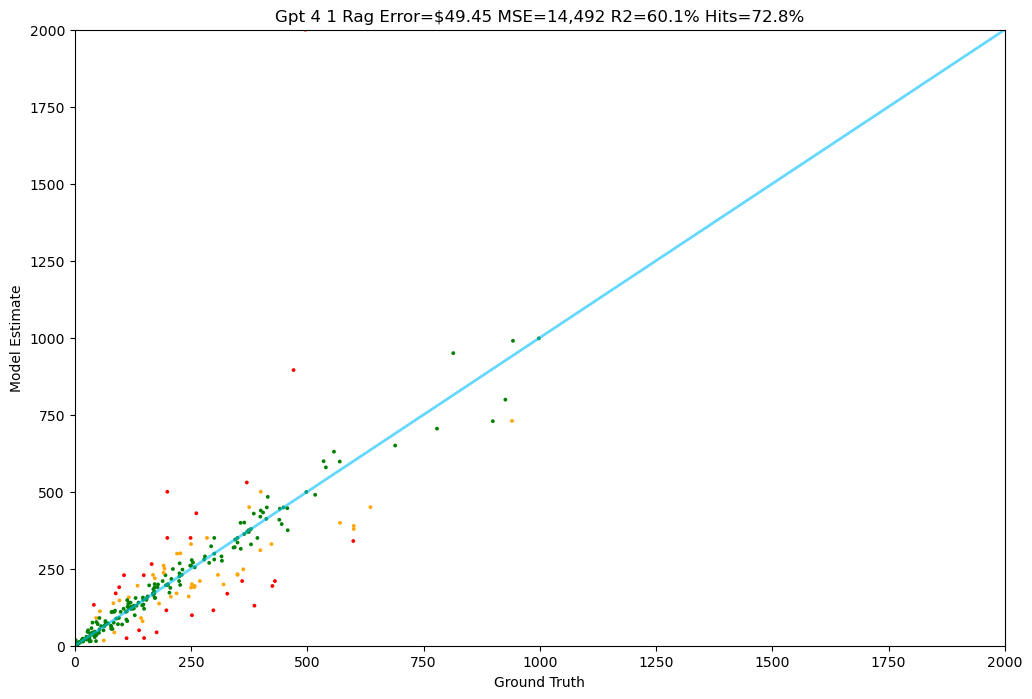

In [43]:
Tester.test(gpt_4_1_rag, test)

In [44]:
root = logging.getLogger()
root.setLevel(logging.INFO)

In [45]:
from price_agents.frontier_agent import FrontierAgent

agent = FrontierAgent(collection)
agent.price("Quadcast HyperX condenser mic, connects via usb-c to your computer for crystal clear audio")

INFO:root:[Frontier Agent] Initializing Frontier Agent
INFO:root:[Frontier Agent] Frontier Agent is set up with DeepSeek
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:root:[Frontier Agent] Frontier Agent is ready
INFO:root:[Frontier Agent] Frontier Agent is using Llama 3.2 to preprocess the description
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:[Frontier Agent] Frontier Agent is vectorizing using all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:[Frontier Agent] Frontier Agent is performing a RAG search of the Chroma datastore to find 5 similar products
INFO:root:[Frontier Agent] Frontier Agent has found similar products
INFO:root:[Frontier Agent] Frontier Agent is about to call DeepSeek with context including 5 similar products
INFO:httpx:HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
INFO:root:[Frontier Agent] Frontier Agent completed - predicting $154.59


154.59

In [46]:
agent.price("Shure MV7+ professional podcaster microphone with usb-c and XLR outputs")

INFO:root:[Frontier Agent] Frontier Agent is using Llama 3.2 to preprocess the description
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:[Frontier Agent] Frontier Agent is vectorizing using all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:[Frontier Agent] Frontier Agent is performing a RAG search of the Chroma datastore to find 5 similar products
INFO:root:[Frontier Agent] Frontier Agent has found similar products
INFO:root:[Frontier Agent] Frontier Agent is about to call DeepSeek with context including 5 similar products
INFO:httpx:HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
INFO:root:[Frontier Agent] Frontier Agent completed - predicting $269.00


269.0